# Make a figure showing the difference between ARCS and filtered ARCS LiDAR

In [234]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [235]:
limit = 30

In [236]:
def set_axes_limited(ax, limit=limit):
    # Set axes to a fixed range around the origin to limit view to +/- 'limit' meters.
    ax.set_xlim3d([-limit, limit])
    ax.set_ylim3d([-limit, limit])
    ax.set_zlim3d([-limit, limit])

In [237]:
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres, cubes as cubes, etc."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [281]:
# Function to plot the bounding box
def plot_bbox(ax, bbox, color):
    # Bounding box order that displays pointpillars predictions correctly   
    x, y, z, dx, dy, dz, yaw = bbox

    
    corners = np.array([
        [x - dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y + dy/2, z + dz/2],
        [x - dx/2, y + dy/2, z + dz/2]
    ])
    

    # Rotate corners around the Z-axis (around their centers)
    rotation_matrix = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]
    ])

    # # Adjust the corners to be about the origin for rotation, then add the [x, y, z] back after rotation
    corners = corners - np.array([x, y, z])
    corners = np.dot(corners, rotation_matrix.T)
    corners += np.array([x, y, z])
    
    # Define the edges of the bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    # Plot the edges
    for edge in edges:
        ax.plot3D(*zip(corners[edge[0]], corners[edge[1]]), color=color, linewidth=1)

In [239]:
def read_kitti_labels(label_path):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] != 'DontCare':
                bbox = [float(value) for value in parts[8:15]]  # Extract the bounding box dimensions and location
                bboxes.append(bbox)
    
    return np.array(bboxes)

In [283]:
def set_velodyne_axes(ax, points, label_path):
    # Filter points that are outside of the axis
    points_within_limit = points[(np.abs(points) <= limit).all(axis=1)]
    
    ax.scatter(points_within_limit[:, 0], points_within_limit[:, 1], points_within_limit[:, 2], s=0.1, c=points_within_limit[:, 3], cmap='viridis', marker='.')
    set_axes_equal(ax)
    set_axes_limited(ax)

    for bbox in read_kitti_labels(label_path):
        plot_bbox(ax, bbox, 'r')
    
    ax.set_title('temp')

In [241]:
frame = '006454'

label_path = '../../data/eval_data/labels/' + frame + '.txt'
bin_path_velodyne = '../../data/eval_data/arcs/' + frame + '.bin'
bin_path_filtered = '../../data/filtered_points/' + frame + '.bin'
bin_path_label_filtered = '../../data/eval_data/arcs_label_filtered/' + frame + '.bin'

points_velodyne = np.fromfile(bin_path_velodyne, dtype=np.float32).reshape(-1, 4)
points_filtered = np.fromfile(bin_path_filtered, dtype=np.float32).reshape(-1, 4)
points_label_filtered = np.fromfile(bin_path_label_filtered, dtype=np.float32).reshape(-1, 4)

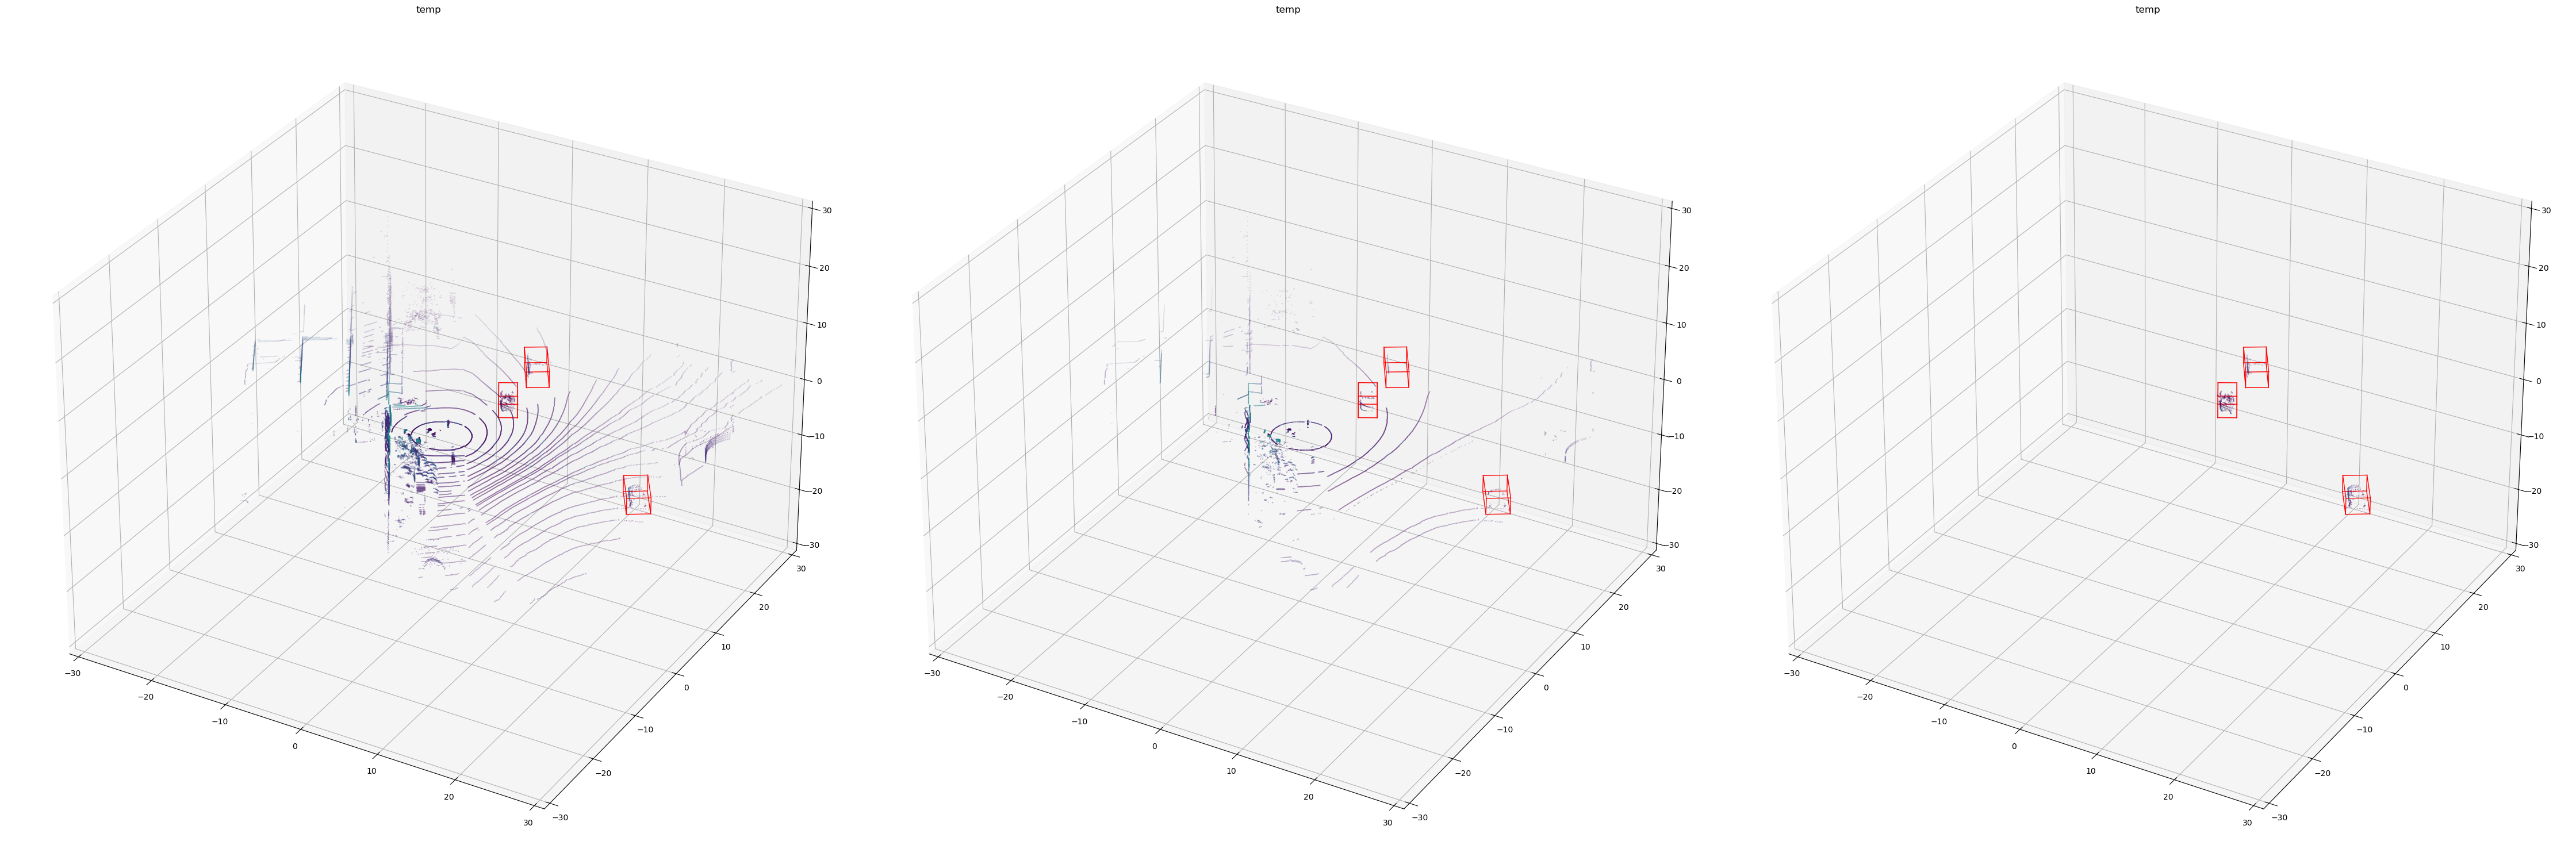

In [287]:
# Figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(45, 15), subplot_kw={'projection': '3d'})

set_velodyne_axes(axes[0], points_velodyne, label_path)
set_velodyne_axes(axes[1], points_filtered, label_path)
set_velodyne_axes(axes[2], points_label_filtered, label_path)

# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
# plt.subplots_adjust(left=-0.1, right=1.1, top=1.1, bottom=-0.1)
plt.subplots_adjust(left=1, right=2, top=2, bottom=-1)

fig.tight_layout()
plt.savefig('arcs_vs_filtered_arcs.png')
plt.show()